# Understanding the Renderings from Virtual Cameras

In [1]:
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import FancyArrowPatch
from mpl_toolkits.mplot3d import proj3d
from matplotlib.lines import Line2D
import torch
import itertools

from run_dnerf_helpers import get_rays
from load_deepdeform import load_deepdeform_data

%load_ext autoreload
%autoreload 2

# Helper function
class Arrow3D(FancyArrowPatch):
    def __init__(self, xs, ys, zs, *args, **kwargs):
        FancyArrowPatch.__init__(self, (0, 0), (0, 0), *args, **kwargs)
        self._verts3d = xs, ys, zs

    def draw(self, renderer):
        xs3d, ys3d, zs3d = self._verts3d
        xs, ys, zs = proj3d.proj_transform(xs3d, ys3d, zs3d, renderer.M)
        self.set_positions((xs[0], ys[0]), (xs[1], ys[1]))
        FancyArrowPatch.draw(self, renderer)

Load DeepDeform Data

In [2]:
scene_name = "office"

images, depth_maps, poses, times, render_poses, render_times, hwf, i_split = load_deepdeform_data(f"./data/{scene_name}", True, 1)
print('Loaded deepdeform', images.shape, render_poses.shape, hwf)

Loaded deepdeform (282, 240, 320, 3) torch.Size([10, 4, 4]) [240, 320, 270.3722426470588]


Get some rays for the first pose (code in `from run_dnerf_helpers import get_rays`):

In [3]:
render_pose = render_poses[0]
print("First pose to be rendered:\n", render_pose)

# Implemented in get_rays(H, W, focal, c2w) function

c2w = render_pose[:3]
H, W, focal = hwf

# Create coordinates for each pixel in the camera coordinate system
i, j = torch.meshgrid(torch.linspace(0, W-1, W), torch.linspace(0, H-1, H))  # pytorch's meshgrid has indexing='ij'     # shape [240, 320], [240, 320]
i = i.t()           # pixel coordinates in X-dir
j = j.t()           # in Y-dir
# The ray directions in the camera coordinate system. 
# Center the X- and Y-coordinates to the image center and scale by focal length. The rays go in the negative Z direction.
dirs = torch.stack([(i-W*.5)/focal, -(j-H*.5)/focal, -torch.ones_like(i)], -1)                                          # shape [240, 320, 3]

# Rotate ray directions from camera frame to the world frame
rays_d = torch.sum(dirs[..., np.newaxis, :] * c2w[:3,:3], -1)  # dot product, equals to: [c2w.dot(dir) for dir in dirs]
# Translate camera frame's origin to the world frame. It is the origin of all rays.
rays_o = c2w[:3,-1].expand(rays_d.shape)

print("Ray directions shape", rays_d.shape)
print("Ray origins shape", rays_o.shape)
print("Ray direction for pixel [0,0] is", rays_d[0,0].tolist(), "with origin at", rays_o[0,0].tolist())

First pose to be rendered:
 tensor([[-0.7071,  0.3536, -0.6124, -2.4495],
        [-0.7071, -0.3536,  0.6124,  2.4495],
        [ 0.0000,  0.8660,  0.5000,  2.0000],
        [ 0.0000,  0.0000,  0.0000,  1.0000]])
Ray directions shape torch.Size([240, 320, 3])
Ray origins shape torch.Size([240, 320, 3])
Ray direction for pixel [0,0] is [1.1877402067184448, -0.3508415222167969, -0.11562976241111755] with origin at [-2.4494895935058594, 2.4494895935058594, 2.0]


/home/kirwul/miniconda3/envs/dnerf/lib/python3.6/site-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


Plot the coordinate frames and the rays.

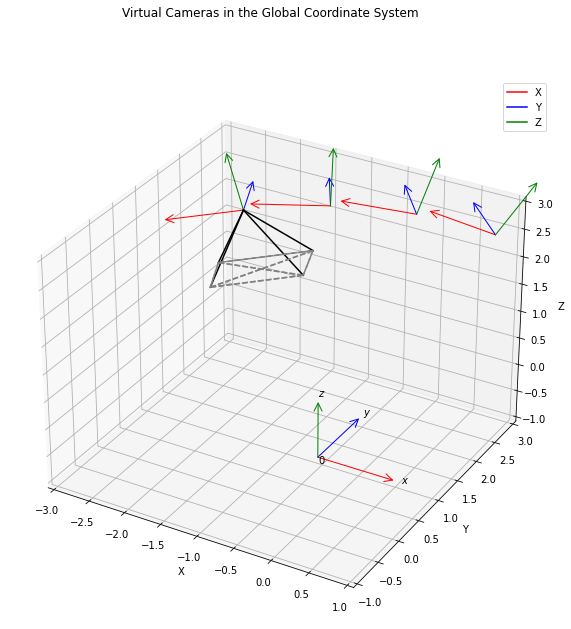

In [4]:
center = [0, 0, 0]
length = 1
width = 1
height = 1
fig = plt.figure(figsize=(10, 10))
ax1 = fig.add_subplot(111, projection='3d')
ax1.set_xlabel('X')
ax1.set_xlim(-3, 1)
ax1.set_ylabel('Y')
ax1.set_ylim(-1, 3)
ax1.set_zlabel('Z')
ax1.set_zlim(-1, 3)

# The world coordinate system
arrow_prop_dict = dict(mutation_scale=20, arrowstyle='->', shrinkA=0, shrinkB=0)
ax1.add_artist(Arrow3D([0, 1], [0, 0], [0, 0], **arrow_prop_dict, color='r'))
ax1.add_artist(Arrow3D([0, 0], [0, 1], [0, 0], **arrow_prop_dict, color='b'))
ax1.add_artist(Arrow3D([0, 0], [0, 0], [0, 1], **arrow_prop_dict, color='g'))
ax1.text(0.0, 0.0, -0.1, r'$0$')
ax1.text(1.1, 0, 0, r'$x$')
ax1.text(0, 1.1, 0, r'$y$')
ax1.text(0, 0, 1.1, r'$z$')

def draw_transformed(pose, ax):
    # The camera coordinate system
    R = pose[:3, :3]
    new_o = pose[:3, 3]
    new_x = R @ np.array([1, 0, 0]) + new_o
    new_y = R @ np.array([0, 1, 0]) + new_o
    new_z = R @ np.array([0, 0, 1]) + new_o
    arrow_prop_dict = dict(mutation_scale=20, arrowstyle='->', shrinkA=0, shrinkB=0)
    ax.add_artist(Arrow3D([new_o[0], new_x[0]], [new_o[1], new_x[1]], [new_o[2], new_x[2]], **arrow_prop_dict, color='r'))
    ax.add_artist(Arrow3D([new_o[0], new_y[0]], [new_o[1], new_y[1]], [new_o[2], new_y[2]], **arrow_prop_dict, color='b'))
    ax.add_artist(Arrow3D([new_o[0], new_z[0]], [new_o[1], new_z[1]], [new_o[2], new_z[2]], **arrow_prop_dict, color='g'))

def draw_cam(rays_o, rays_d, ax):
    H, W, _ = rays_d.shape
    ps = []
    # plot camera rays
    for iy, ix in [[0, 0], [H-1, 0], [0, W-1], [H-1, W-1]]:
        o = rays_o[iy, ix]
        d = rays_d[iy, ix]
        p = o + d
        ax.plot([o[0], p[0]], [o[1], p[1]], [o[2], p[2]], color="black")
        ps.append(p)
    # plot camera frame
    for p1, p2 in list(itertools.permutations(ps, 2)):
        ax.plot([p1[0], p2[0]], [p1[1], p2[1]], [p1[2], p2[2]], color="grey", ls="--")

# Draw camera coordinate frames
for pose in render_poses[:8:2]:
    draw_transformed(pose, ax1)

plt.legend(handles=[Line2D([0], [0], color='r'), Line2D([0], [0], color='b'), Line2D([0], [0], color='g')], labels=["X", "Y", "Z"])

draw_cam(rays_o, rays_d, ax1)

fig.suptitle("Virtual Cameras in the Global Coordinate System")

plt.show()